In [1]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
sys.path.append("../")

In [4]:
from Transformers import ChannelsFirst, ToTensor, Cut, Rescale, splitter, splitter_train_val_test

In [5]:
from DataSets import UNetDataSetFromNpz, UNetDatasetFromFolders

In [6]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [7]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT

In [8]:
epochs=50
coeff_mask = 0.75

In [9]:
model_name = "../model/trained_cUNet_pytorch_regression_{}epochs_coeff_mask{}_validation_on_npz_notranspose.pkl".format(epochs, coeff_mask)

In [10]:
model_inference = cUNet(out_size=1)

In [11]:
model_inference.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Test trained model on 15mm

In [13]:
dataset_folder = os.path.join(data_dir,"dataset", "first_batch")

In [14]:
composed = transforms.Compose([Cut(),Rescale(.25), ChannelsFirst(), ToTensor()])

In [15]:
complete_dataset = UNetDatasetFromFolders(dataset_folder, transform=composed)

In [17]:
len(complete_dataset)

3000

In [18]:
dataset_loader = DataLoader(complete_dataset, batch_size=16, shuffle=True, num_workers=4)

In [19]:
model_inference.eval()
model_inference.to(device)

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

batch 1
1: true_dist: 15, pred_dist: [15.369154]


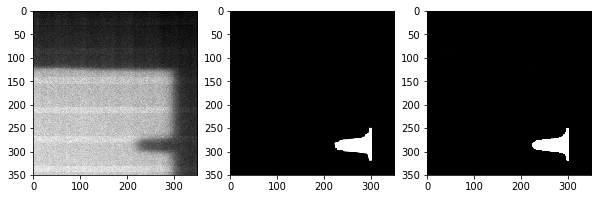

2: true_dist: 15, pred_dist: [15.673879]


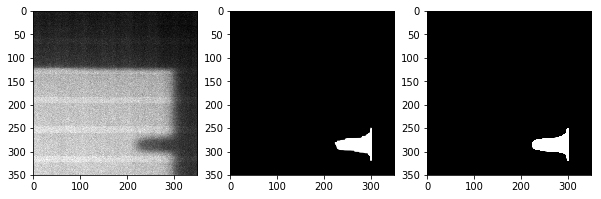

3: true_dist: 35, pred_dist: [29.371834]


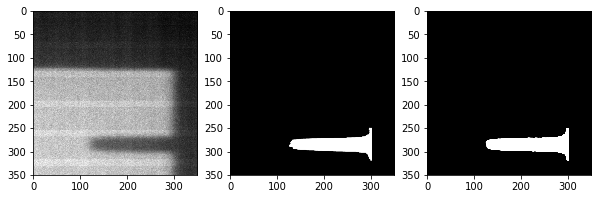

4: true_dist: 2, pred_dist: [1.8635489]


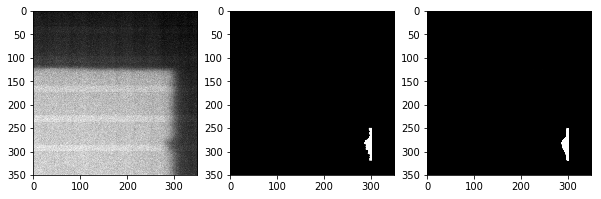

5: true_dist: 2, pred_dist: [1.8788251]


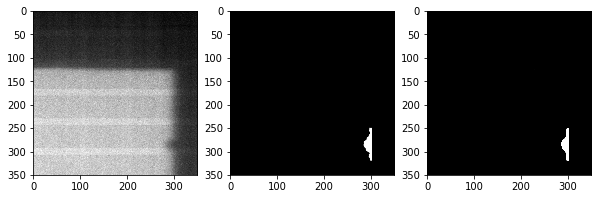

6: true_dist: 4, pred_dist: [3.8751268]


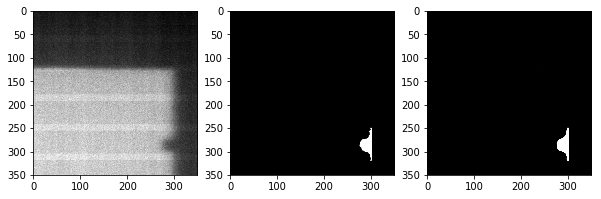

7: true_dist: 15, pred_dist: [15.560555]


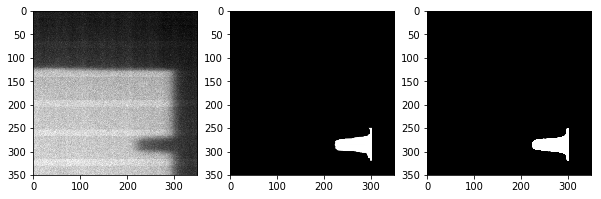

8: true_dist: 2, pred_dist: [2.04959]


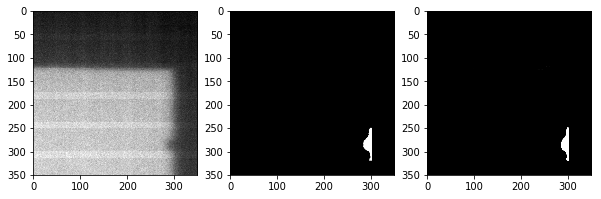

9: true_dist: 15, pred_dist: [15.748951]


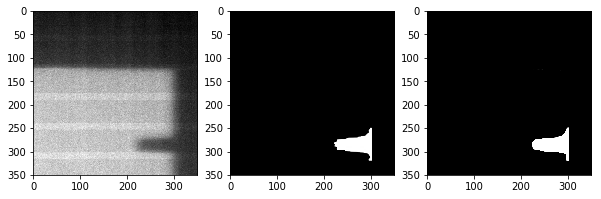

10: true_dist: 35, pred_dist: [29.231476]


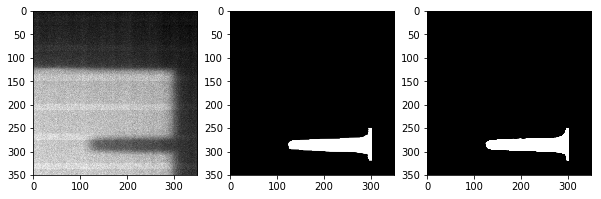

11: true_dist: 30, pred_dist: [27.838242]


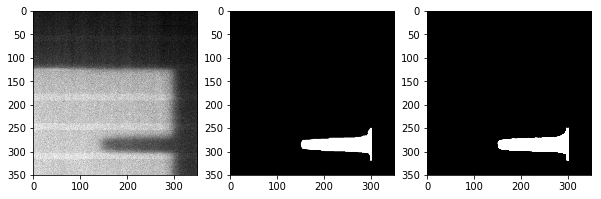

12: true_dist: 35, pred_dist: [29.45664]


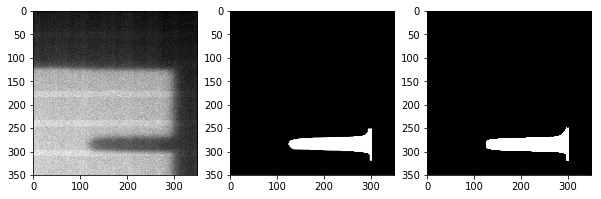

13: true_dist: 10, pred_dist: [9.977257]


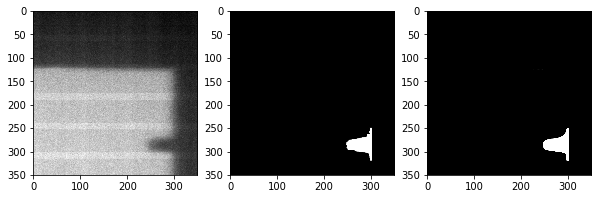

14: true_dist: 4, pred_dist: [3.9623737]


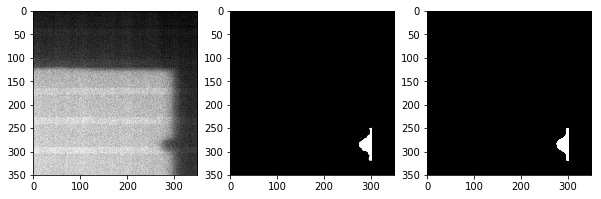

15: true_dist: 1, pred_dist: [1.1510535]


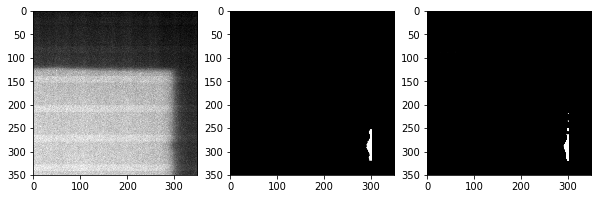

16: true_dist: 10, pred_dist: [9.92985]


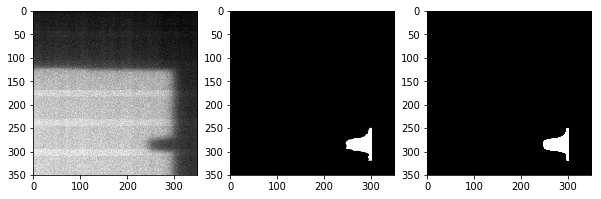

batch 2
1: true_dist: 20, pred_dist: [20.389168]


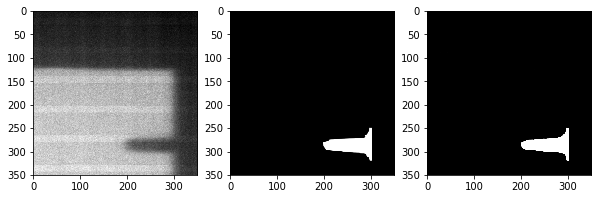

2: true_dist: 15, pred_dist: [15.432557]


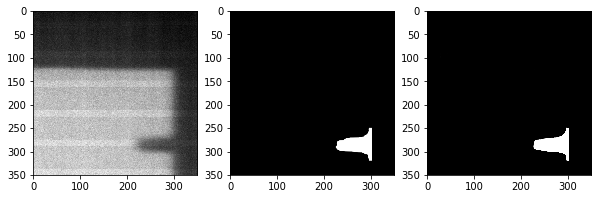

3: true_dist: 10, pred_dist: [9.870806]


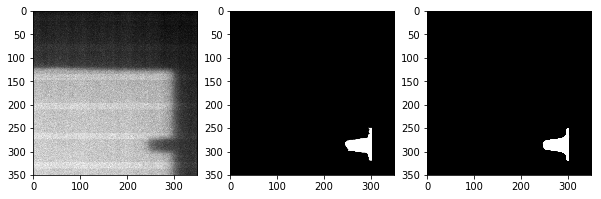

4: true_dist: 20, pred_dist: [20.807043]


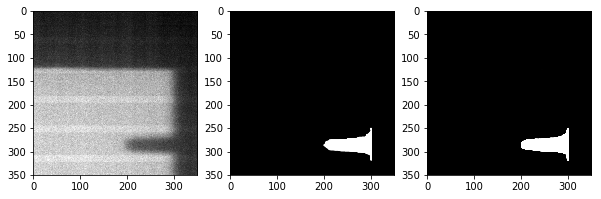

5: true_dist: 10, pred_dist: [9.842077]


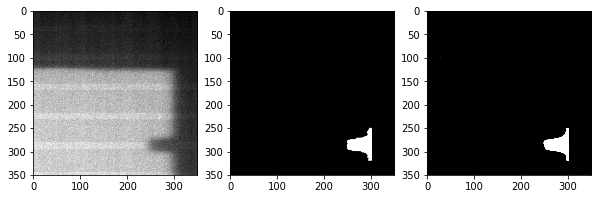

6: true_dist: 35, pred_dist: [29.481201]


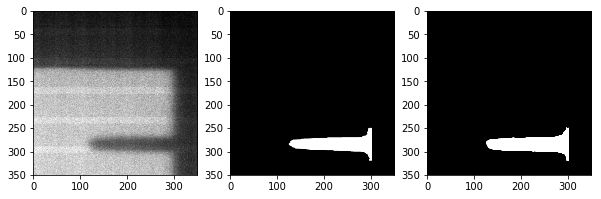

7: true_dist: 10, pred_dist: [9.836634]


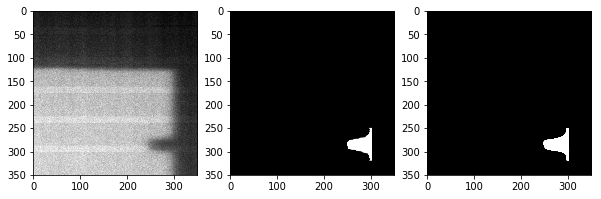

8: true_dist: 10, pred_dist: [9.828204]


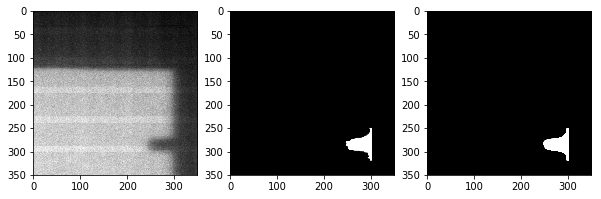

9: true_dist: 2, pred_dist: [1.9479103]


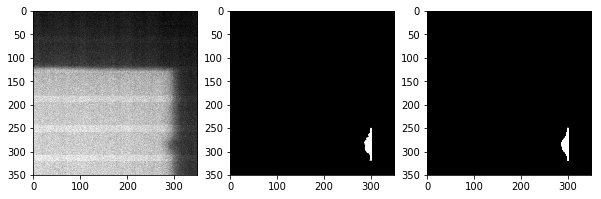

10: true_dist: 20, pred_dist: [20.74378]


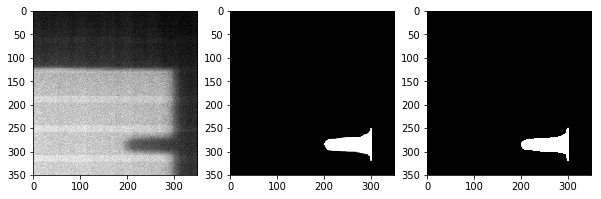

11: true_dist: 15, pred_dist: [15.723176]


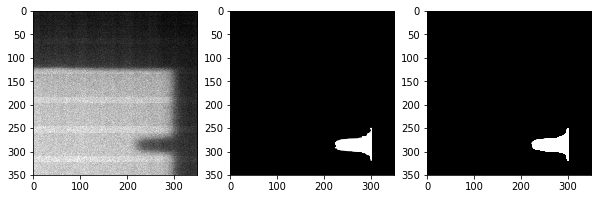

12: true_dist: 15, pred_dist: [15.449426]


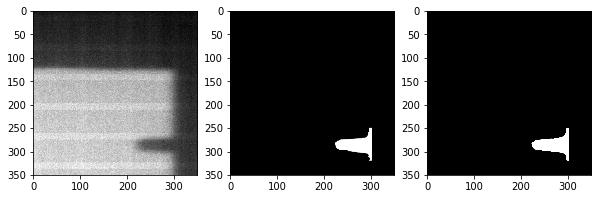

13: true_dist: 20, pred_dist: [20.462954]


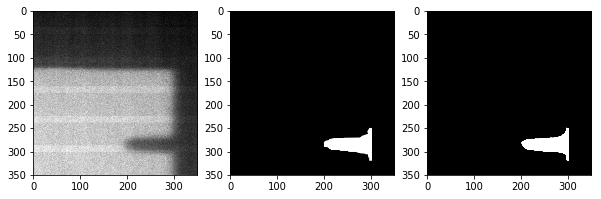

14: true_dist: 1, pred_dist: [1.1492518]


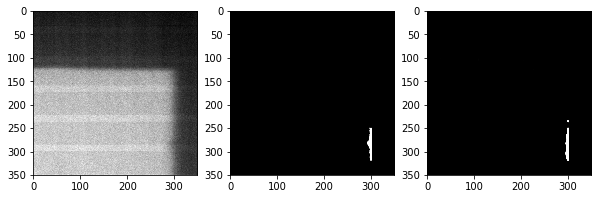

15: true_dist: 10, pred_dist: [9.90433]


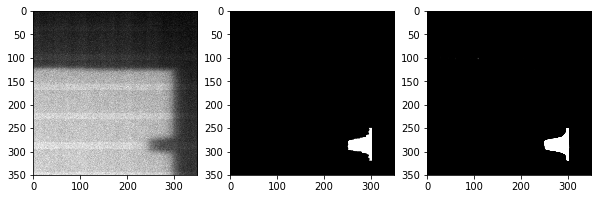

16: true_dist: 15, pred_dist: [15.216457]


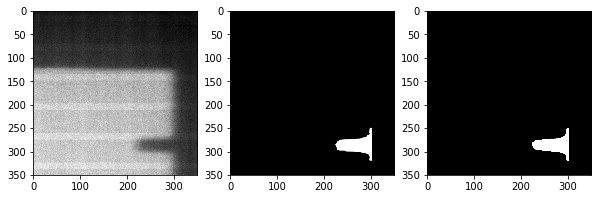

In [20]:
for i, batch in enumerate(dataset_loader):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_cl, pr_msk, pr_cl) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_classes.cpu().detach().numpy())):
    
        true_dist = tr_cl
        pred_dist = pr_cl
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [23]:
y_true = []
y_pred = []

for i, batch in tqdm.tqdm(enumerate(dataset_loader)):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_classes = model_inference(true_images.float().to(device))
#    print("batch {}".format(i + 1))
    for j, (img, tr_cl, pr_cl) in enumerate(zip(true_images,
                                                true_dists.cpu().detach().numpy(),
                                                pred_classes.cpu().detach().numpy())):
        true_dist = tr_cl
        pred_dist = pr_cl
        y_true.append(true_dist)
        y_pred.append(pred_dist)




188it [03:19,  1.32it/s]


In [24]:
y_pred = np.asarray(y_pred).ravel()
y_true = np.asarray(y_true)

print("mse: {}".format(mean_squared_error(y_true, y_pred)))

mse: 3.599400019298777


In [30]:
def get_idx(arr, key):
    return np.where(arr==key)[0]

In [67]:
def idx_mse(dist, true_arr = y_true, preds_arr = y_pred):
    idx = np.where(true_arr==dist)[0]
    mse = mean_squared_error(true_arr[idx], preds_arr[idx])
    print(dist, mse)
    return idx, mse 

In [68]:
idx_1, mse_1 = idx_mse(1)
idx_2, mse_2 = idx_mse(2)
idx_3, mse_3 = idx_mse(3)
idx_4, mse_4 = idx_mse(4)
idx_10, mse_10 = idx_mse(10)
idx_15, mse_15 = idx_mse(15)
idx_20, mse_20 = idx_mse(20)
idx_25, mse_25 = idx_mse(25)
idx_30, mse_30 = idx_mse(30)
idx_35, mse_35 = idx_mse(35)

1 0.04211231654485237
2 0.011488652310405408
3 0.04206544164218902
4 0.03287234894741687
10 0.016197459908150146
15 0.21195150013583164
20 0.3564663015536523
25 0.02678408387451782
30 5.0104033296366834
35 30.243658758434066


In [69]:
distances = [1,2,3,4,10,15,20,25,30,35]

In [70]:
errors = [idx_mse(i)[1] for i in distances]

1 0.04211231654485237
2 0.011488652310405408
3 0.04206544164218902
4 0.03287234894741687
10 0.016197459908150146
15 0.21195150013583164
20 0.3564663015536523
25 0.02678408387451782
30 5.0104033296366834
35 30.243658758434066


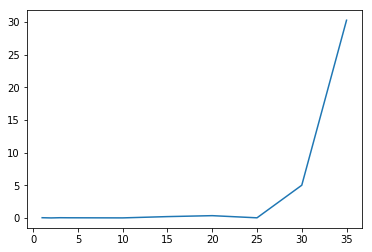

In [50]:
plt.plot(distances, errors)

#### let's round the numbers

In [51]:
y_pred_round = np.round(y_pred)

In [53]:
mean_squared_error(y_true, y_pred_round)

3.601

In [54]:
errors_round = [idx_mse(i, preds_arr=y_pred_round)[1] for i in distances]

0.006666666666666667
0.0
0.023333333333333334
0.0
0.0
0.31666666666666665
0.66
0.006666666666666667
4.35
30.64666666666667


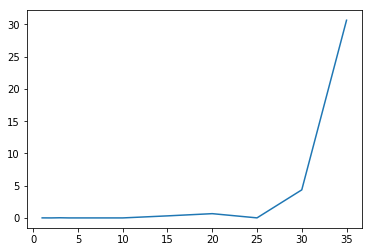

In [55]:
plt.plot(distances, errors_round)

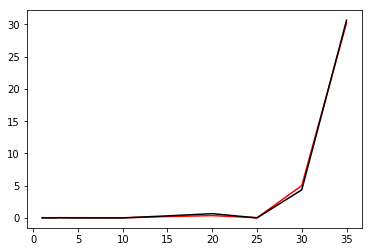

In [56]:
plt.plot(distances, errors, c='red')
plt.plot(distances, errors_round,c= 'k')

In [71]:
idx_30,mse_30 = idx_mse(30)
y_pred[idx_30]

30 5.0104033296366834


array([27.986582, 28.026556, 27.72373 , 27.811775, 27.932268, 27.359957,
       27.818876, 27.983318, 27.882492, 27.725315, 27.713177, 27.765678,
       27.637033, 27.523983, 27.567942, 27.425829, 27.82559 , 27.690565,
       27.984865, 27.917013, 27.778378, 28.040136, 27.481829, 27.611662,
       27.642942, 27.79515 , 27.646313, 27.465073, 27.76129 , 27.91    ,
       27.737026, 27.509703, 27.894827, 27.699438, 27.694891, 27.93263 ,
       27.472164, 27.616257, 27.936853, 27.552067, 27.784739, 27.71885 ,
       27.796564, 27.952911, 27.836033, 27.54675 , 27.515575, 27.64125 ,
       27.64443 , 27.696066, 27.827785, 27.646994, 27.821684, 27.95417 ,
       27.70179 , 27.714577, 27.623833, 27.88761 , 27.87264 , 27.320623,
       27.73957 , 27.974047, 27.436403, 27.95408 , 27.685434, 27.723726,
       27.841635, 27.966484, 27.652355, 27.765484, 27.629457, 27.414442,
       27.928679, 27.647018, 27.906307, 27.808693, 27.457172, 28.036201,
       27.698597, 27.890629, 27.456787, 27.983831, 

In [72]:
idx_35,mse_35 = idx_mse(35)
y_pred[idx_35]

35 30.243658758434066


array([29.59767 , 29.320791, 29.390598, 29.807934, 29.616762, 29.744576,
       29.392147, 29.382185, 29.900393, 29.398968, 29.401497, 29.408516,
       29.631178, 29.07483 , 29.388897, 29.382015, 29.413252, 29.311235,
       29.589397, 29.888641, 29.943018, 29.730438, 29.193474, 29.525663,
       29.096924, 29.286648, 29.54982 , 30.058113, 29.773735, 29.653233,
       29.579344, 29.859184, 29.417639, 28.99581 , 29.43804 , 29.465359,
       29.507853, 29.377157, 29.358126, 29.857805, 29.504051, 29.462698,
       29.224102, 29.111301, 29.520157, 29.290533, 29.480091, 29.485119,
       29.900494, 29.520094, 29.590508, 29.597416, 29.568401, 29.559921,
       29.203527, 29.276918, 29.400455, 29.513615, 29.723597, 29.526913,
       29.669685, 29.336956, 29.287613, 29.564425, 29.395681, 29.658718,
       29.314184, 29.543741, 29.836115, 29.899475, 29.316782, 29.307745,
       29.253971, 29.594637, 29.763306, 29.384876, 29.272425, 29.446136,
       29.68673 , 29.155724, 29.21534 , 29.538736, 

In [73]:
idx_30_round,mse_30_round = idx_mse(30, preds_arr=y_pred_round)
y_pred_round[idx_30]

30 4.35


array([28., 28., 28., 28., 28., 27., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 27., 28., 28., 28., 28., 28., 28., 27., 28., 28., 28.,
       28., 27., 28., 28., 28., 28., 28., 28., 28., 28., 27., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 27., 28., 28., 27., 28., 28.,
       28., 28., 28., 28., 28., 28., 27., 28., 28., 28., 28., 27., 28.,
       28., 28., 27., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 27., 28., 27., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 27.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 27., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 27., 28

In [74]:
idx_35_round,mse_35_round = idx_mse(35, preds_arr=y_pred_round)
y_pred_round[idx_35]

35 30.64666666666667


array([30., 29., 29., 30., 30., 30., 29., 29., 30., 29., 29., 29., 30.,
       29., 29., 29., 29., 29., 30., 30., 30., 30., 29., 30., 29., 29.,
       30., 30., 30., 30., 30., 30., 29., 29., 29., 29., 30., 29., 29.,
       30., 30., 29., 29., 29., 30., 29., 29., 29., 30., 30., 30., 30.,
       30., 30., 29., 29., 29., 30., 30., 30., 30., 29., 29., 30., 29.,
       30., 29., 30., 30., 30., 29., 29., 29., 30., 30., 29., 29., 29.,
       30., 29., 29., 30., 29., 29., 29., 29., 29., 29., 29., 30., 29.,
       29., 30., 29., 30., 29., 30., 30., 30., 30., 30., 30., 29., 29.,
       29., 29., 29., 29., 30., 29., 30., 29., 29., 29., 30., 29., 30.,
       29., 29., 29., 30., 30., 30., 29., 29., 30., 29., 29., 30., 29.,
       30., 30., 29., 30., 29., 30., 29., 30., 29., 30., 30., 29., 29.,
       29., 30., 30., 29., 30., 29., 29., 29., 30., 30., 29., 30., 29.,
       30., 30., 30., 30., 30., 30., 30., 29., 30., 29., 29., 29., 30.,
       29., 29., 29., 30., 29., 30., 29., 29., 29., 29., 30., 29